Постройте воронку, которая показывала бы в динамике по неделям и месяцам:
1.   сколько клиентов посещает наш сайт;
2.   какая доля из них (посетивших) регистрируется на нём/подаёт заявку на игру/приходит на игру (неважно, в каком месяце);
3.   какая доля из них (зарегестрировавшихся) подает заявку на игру (неважно, в каком месяце);
4.   какая доля из них (зарегестрировавшихся и подавших заявку на игру) по факту приходит на игру (неважно, в каком месяце).

Изобразите:

1.   Кол-во клиентов, которые посещают наш сайт / регистрируются на сайте / подают заявку на игру/ приходят на игру помесячно и понедельно. Добавьте легенду, подписи осей и название диаграммы.

Дополнительно сделайте табличку с долей каждой группы от общего числа посетителей для помесячного графика.

2.   Помесячно (и затем понедельно) на одной гистограмме
- кол-во клиентов, которые посетили сайт / зарегистрировались / подали заявку на игру / пришли на игру и долю зарегистрировавшихся от посетителей / долю подавших заявку от регистраций / долю пришедших хотя бы на 1 игру от подававших заявку (абсолюты и конверсии должны быть на разных осях соответственно)


Какие выводы можно сделать исходя из построенных конверсий, какие точки роста продукта вы видите?

// Всего можно получить 6 баллов
*   построена полная воронка с помощью sql-запроса - 2 балла
*   выполнен 1 пункт - 2 балла
*   выполнен 2 пункт - 2 балла



In [ ]:
#Предварительно надо установить pandas, psycopg2, matplotlib, seaborn, plotly
#То, что нам необходимо, устанавливаем в командной строке с помощью pip:
#pip install pandas
#pip3 install psycopg2-binary
#python -m pip install -U matplotlib
#pip install seaborn[stats]
#pip install plotly

import psycopg2
import pandas as pd
from matplotlib import pyplot as plt
#import seaborn as sns
from plotly import graph_objects as go
from plotly.data import tips
#import plotly.graph_objects as go
%matplotlib inline

#1. Подключаемся к базе данных с помощью Python в JupyterNotebook
conn = psycopg2.connect(
    host="158.160.110.228",
    port=5432,
    database="postgres",
    user="student",
    password="JvLda93aA",
)

In [ ]:
#2. Собираем датасет с необходимыми полями
df_client = pd.read_sql("SELECT * FROM msu_analytics.client", con=conn)
df_account = pd.read_sql("SELECT * FROM msu_analytics.account", con=conn)
df_application = pd.read_sql("SELECT * FROM msu_analytics.application", con=conn)
df_game = pd.read_sql("SELECT * FROM msu_analytics.game", con=conn)

# создаём dataframe
df = pd.merge(df_client, df_account, on='client_rk', how='left')
df = pd.merge(df, df_application, on='account_rk', how='left')
df = pd.merge(df, df_game, on='game_rk', how='left')

columns_to_keep = ['client_rk', 'visit_dttm', 'account_rk', 'game_rk', 'game_flg']
columns_to_drop = [col for col in df.columns if col not in columns_to_keep]
# Чистим табличу
for col in columns_to_drop:
    del df[col]
df = df[~df.duplicated(subset='client_rk') | (df['game_flg'] == 1)]
df = df.drop_duplicates(subset=['client_rk'])


<ipython-input-47-136f7681e90a>:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_client = pd.read_sql("SELECT * FROM msu_analytics.client", con=conn)
<ipython-input-47-136f7681e90a>:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_account = pd.read_sql("SELECT * FROM msu_analytics.account", con=conn)
<ipython-input-47-136f7681e90a>:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_application = pd.read_sql("SELECT * FROM msu_analytics.application", con=conn)
<ipython-input-47-136f7681e90a>:5: UserWarning: pandas onl

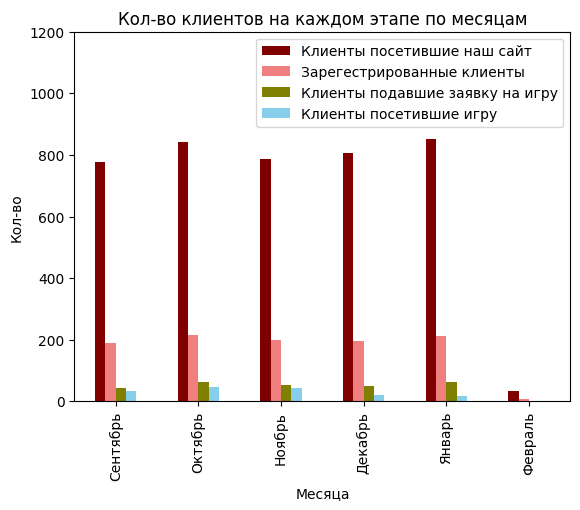

In [ ]:
# табличка по месяцам
#Преобразование столбца visit_dttm в формат даты и создание нового столбца для месяцев
df['visit_dttm'] = pd.to_datetime(df['visit_dttm'])
df['month'] = df['visit_dttm'].dt.month

funnel_month = df.groupby('month').agg({
    'client_rk': 'nunique',
    'account_rk': 'nunique',
    'game_rk': 'nunique',
    'game_flg': 'sum'
}).reset_index()


funnel_month = funnel_month.iloc[[2, 3, 4, 5, 0, 1]]
funnel_month.set_index('month', inplace=True)
colors = ['maroon', 'lightcoral', 'olive', 'skyblue']
labels = ['Клиенты посетившие наш сайт', 'Зарегестрированные клиенты', 'Клиенты подавшие заявку на игру',
          'Клиенты посетившие игру']


funnel_month.plot(kind='bar', color = colors)
plt.xlabel('Месяца')
plt.ylabel('Кол-во')
plt.xticks([0, 1, 2, 3, 4, 5], ['Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь', 'Январь', 'Февраль'])
plt.legend( labels = labels)
plt.ylim(0, 1200)
plt.title('Кол-во клиентов на каждом этапе по месяцам')
plt.show()

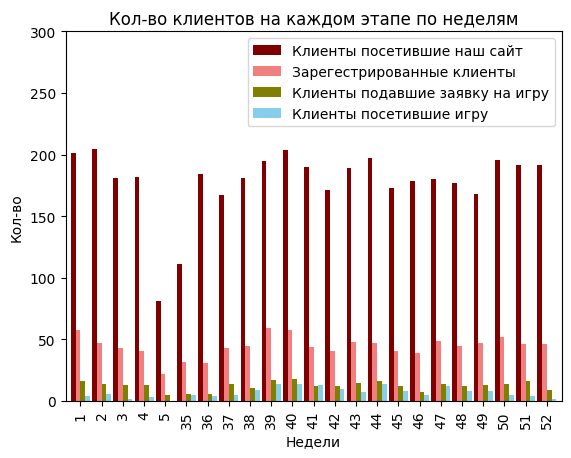

In [ ]:
#Табличка по неделям
df['week'] = df['visit_dttm'].dt.isocalendar().week

funnel_week = df.groupby('week').agg({
    'client_rk': 'nunique',
    'account_rk': 'nunique',
    'game_rk': 'nunique',
    'game_flg': 'sum'
}).reset_index()


funnel_week.set_index('week', inplace=True)
colors = ['maroon', 'lightcoral', 'olive', 'skyblue']
labels = ['Клиенты посетившие наш сайт', 'Зарегестрированные клиенты', 'Клиенты подавшие заявку на игру',
          'Клиенты посетившие игру']

funnel_week.plot(kind='bar', color = colors, width=0.9)
plt.xlabel('Недели')
plt.ylabel('Кол-во')
plt.legend( labels = labels)
plt.ylim(0, 300)
plt.title('Кол-во клиентов на каждом этапе по неделям')
plt.show()


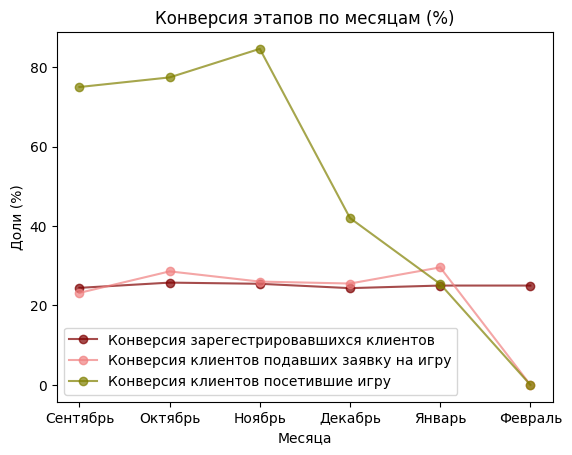

,level_0,index,month,client_rk,account_rk,game_rk,game_flg,conv_client_account,conv_game_client,conv_game_flg_client
0,0,0,9,778,190,44,33.0,24.421594,23.157895,75.000000
1,1,1,10,843,217,62,48.0,25.741400,28.571429,77.419355
2,2,2,11,786,200,52,44.0,25.445293,26.000000,84.615385
3,3,3,12,805,196,50,21.0,24.347826,25.510204,42.000000
4,4,4,1,852,213,63,16.0,25.000000,29.577465,25.396825
5,5,5,2,32,8,0,0.0,25.000000,0.000000,0.000000


In [ ]:
#3а. Считаем конверсии, точнее доли, и делаем визуализацию на Python - помесячно
#Конверсия = количество посетителей, совершивших целевое действие / общее количество всех посетителей * 100%.
funnel_month['conv_client_account'] = funnel_month['account_rk']/funnel_month['client_rk']*100
funnel_month['conv_game_client'] = funnel_month['game_rk']/funnel_month['account_rk']*100
funnel_month['conv_game_flg_client'] = funnel_month['game_flg']/funnel_month['game_rk']*100
funnel_month.fillna(0, inplace=True)
funnel_month.reset_index(drop=True)
month_conv = funnel_month.loc[:, [ 'conv_client_account', 'conv_game_client', 'conv_game_flg_client']]

labels_conv = ['Конверсия зарегестрировавшихся клиентов', 'Конверсия клиентов подавших заявку на игру', 'Конверсия клиентов посетившие игру']
month_conv.plot(kind='line', color = colors, alpha=0.7, marker = 'o')
plt.xlabel('Месяца')
plt.ylabel('Доли (%)')
plt.xticks([0, 1, 2, 3, 4, 5], ['Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь', 'Январь', 'Февраль'])
plt.legend( labels = labels_conv)
plt.title('Конверсия этапов по месяцам (%)')
plt.show()
funnel_month # воронка по месяцам
#month_conv

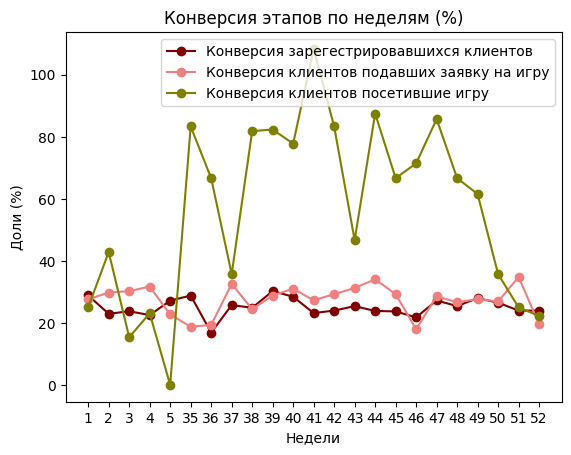

,level_0,index,week,client_rk,account_rk,game_rk,game_flg,conv_client_account,conv_game_client,conv_game_flg_client
0,0,0,1,201,58,16,4.0,28.855721,27.586207,25.000000
1,1,1,2,205,47,14,6.0,22.926829,29.787234,42.857143
2,2,2,3,181,43,13,2.0,23.756906,30.232558,15.384615
3,3,3,4,182,41,13,3.0,22.527473,31.707317,23.076923
4,4,4,5,81,22,5,0.0,27.160494,22.727273,0.000000
5,5,5,35,111,32,6,5.0,28.828829,18.750000,83.333333
6,6,6,36,184,31,6,4.0,16.847826,19.354839,66.666667
7,7,7,37,167,43,14,5.0,25.748503,32.558140,35.714286
8,8,8,38,181,45,11,9.0,24.861878,24.444444,81.818182
9,9,9,39,195,59,17,14.0,30.256410,28.813559,82.352941


In [ ]:
#3б. Считаем конверсии, точнее доли, и делаем визуализацию на Python - понедельно
#Конверсия = количество посетителей, совершивших целевое действие / общее количество всех посетителей * 100%.
funnel_week['conv_client_account'] = funnel_week['account_rk']/funnel_week['client_rk']*100
funnel_week['conv_game_client'] = funnel_week['game_rk']/funnel_week['account_rk']*100
funnel_week['conv_game_flg_client'] = funnel_week['game_flg']/funnel_week['game_rk']*100
funnel_week.reset_index(drop=True)
week_conv = funnel_week.loc[:, [ 'conv_client_account', 'conv_game_client', 'conv_game_flg_client']]

labels_conv = ['Конверсия зарегестрировавшихся клиентов', 'Конверсия клиентов подавших заявку на игру', 'Конверсия клиентов посетившие игру']
week_conv.plot(kind='line', color = colors, marker ='o')
plt.xlabel('Недели')
plt.ylabel('Доли (%)')
plt.legend( labels = labels_conv)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22], ['1','2','3','4','5','35','36','37','38','39','40','41','42','43','44','45','46','47','48','49','50','51','52'])
plt.title('Конверсия этапов по неделям (%)')
plt.show()
funnel_week #воронка по неделям

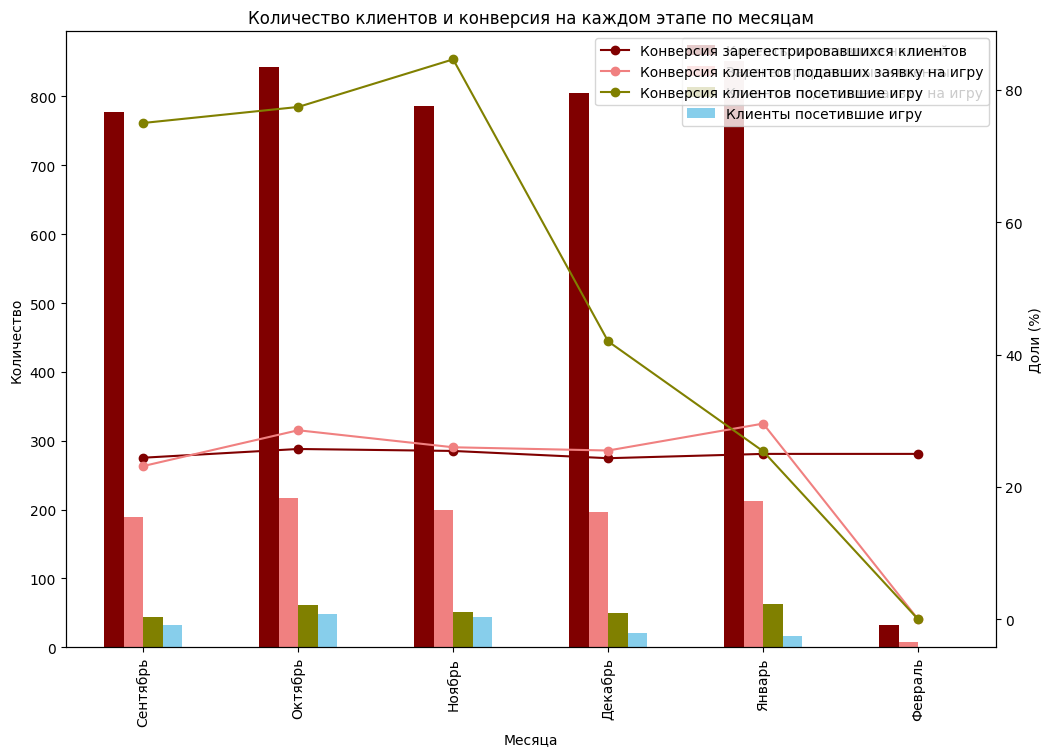

In [ ]:
#4а. Теперь то же самое, но на одном графике - помесячно
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()
funnel_month_1 = funnel_month.loc[:, [ 'client_rk', 'account_rk', 'game_rk', 'game_flg']]

funnel_month_1.plot(kind='bar', color=colors, ax=ax1)
ax1.set_ylabel('Количество')
ax1.set_xlabel('Месяца')
ax1.legend(labels=labels)
ax1.set_title('Количество клиентов и конверсия на каждом этапе по месяцам')

month_conv.plot(kind='line',color=colors, ax=ax2, marker='o')
ax2.set_ylabel('Доли (%)')
plt.xticks([0, 1, 2, 3, 4, 5], ['Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь', 'Январь', 'Февраль'])
ax2.legend(labels=labels_conv)
plt.show()


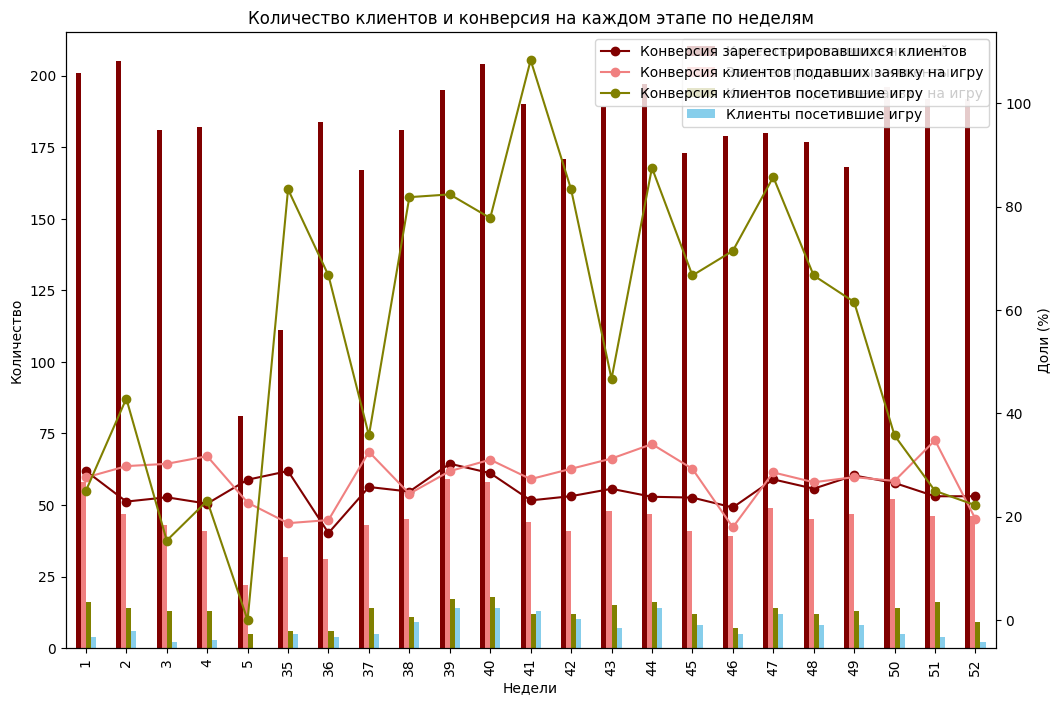

In [ ]:
#4а. Теперь то же самое, но на одном графике - понедельно
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()
funnel_week_1 = funnel_week.loc[:, [ 'client_rk', 'account_rk', 'game_rk', 'game_flg']]

funnel_week_1.plot(kind='bar', color=colors, ax=ax1)
ax1.set_ylabel('Количество')
ax1.set_xlabel('Недели')
ax1.legend(labels=labels)
ax1.set_title('Количество клиентов и конверсия на каждом этапе по неделям')

week_conv.plot(kind='line', color=colors, ax=ax2, marker='o')
ax2.set_ylabel('Доли (%)')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22], ['1','2','3','4','5','35','36','37','38','39','40','41','42','43','44','45','46','47','48','49','50','51','52'])
ax2.legend(labels=labels_conv)

plt.show()

In [ ]:
#ВЫВОДЫ:
По графику конверсии по месяцам можно наблюдать, что доля зарегестрировавшихся клиентов и доля зарегестрировавшихся на игру стабильно в диапазоне
25-30%, а процентная доля клиентов посетивших игру чаще в диапазоне 40-80%, что является хорошим результатом

По графику конверсии по неделям можно наблюдать довольно не равномерную картину в доле клиентов посетивших игру. Клиенты зарегистровавшие и
клиенты подавшие зявык на игру примерно в диапазоне 20-35%.
#ТОЧКИ РОСТА:
Конверсия по месяцам: точки резкого спада клиентов посетивших игру наблюдается в Декабре, Январе, Феврале и резкий спад в феврале клиентов
подавших на игру, т.е. есть проблемы на этапе подаче заявки на игру, многие зарегестрированные клиенты отсеиваются на этом шаге, аналогично и
для посетивших игру клиентов. В свою очередь сильных скачков не наблюдается.
Конверсия по неделям: точки роста можно наблюдать в клиентах посетивших игру:35 неделя, 41 неделя(глобальный максимум)
